In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf

2023-07-28 21:41:21.927363: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 21:41:27.602770: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/aryan/.local/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
BATCH_SIZE = 6
IMG_SIZE = (160, 160)
train_dir = 'data/train'
test_dir = 'data/test'
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                    shuffle=True,
                                                    batch_size=BATCH_SIZE,
                                                    image_size=IMG_SIZE)

Found 251 files belonging to 3 classes.
Found 66 files belonging to 3 classes.


2023-07-28 21:41:32.065658: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: UNKNOWN ERROR (100)


['Covid', 'Normal', 'Viral Pneumonia']


2023-07-28 21:41:32.548285: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 36578304 exceeds 10% of free system memory.
2023-07-28 21:41:32.589382: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25321440 exceeds 10% of free system memory.


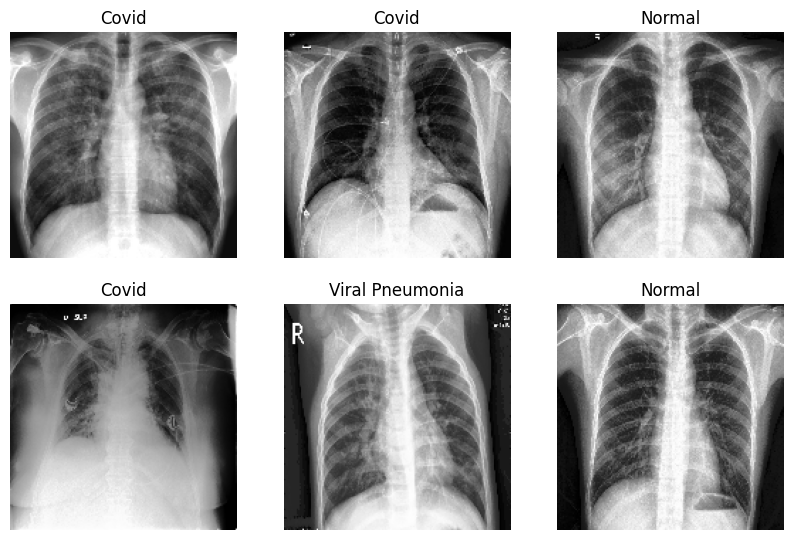

In [3]:
class_names = train_dataset.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [4]:
test_batches = tf.data.experimental.cardinality(test_dataset)
validation_dataset = test_dataset.take(test_batches // 2)
validation_dataset = test_dataset.skip(test_batches // 2)

In [5]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of train batches: 42
Number of test batches: 11
Number of validation batches: 6


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

2023-07-28 21:41:34.305040: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25321440 exceeds 10% of free system memory.
2023-07-28 21:41:34.305203: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 36578304 exceeds 10% of free system memory.


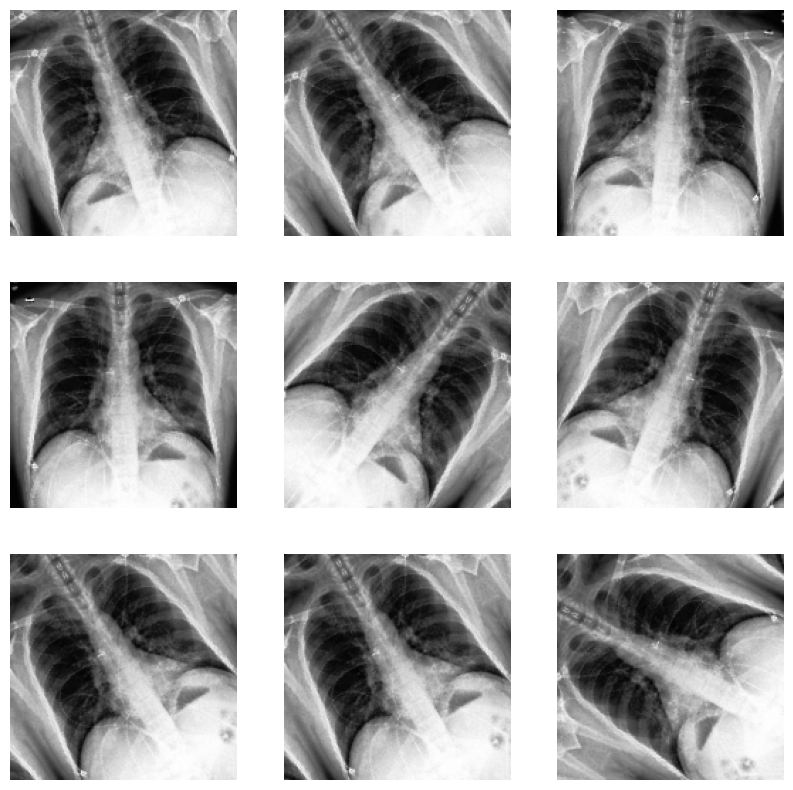

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False)

base_model.trainable = False
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [9]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2023-07-28 21:41:39.669410: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 36578304 exceeds 10% of free system memory.


(6, 5, 5, 1280)


In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)


In [11]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [12]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

len(model.trainable_variables)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

2

In [14]:
initial_epochs = 50

loss0, accuracy0 = model.evaluate(validation_dataset)

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

6/6 [==============================] - 1s 82ms/step - loss: 0.2572 - accuracy: 0.3611
Epoch 1/50
42/42 [==============================] - 4s 89ms/step - loss: 0.4003 - accuracy: 0.3705 - val_loss: 0.4339 - val_accuracy: 0.4444
Epoch 2/50
42/42 [==============================] - 4s 88ms/step - loss: 0.2759 - accuracy: 0.3506 - val_loss: 0.0031 - val_accuracy: 0.4167
Epoch 3/50
42/42 [==============================] - 4s 83ms/step - loss: 0.1585 - accuracy: 0.3546 - val_loss: -0.1200 - val_accuracy: 0.4167
Epoch 4/50
42/42 [==============================] - 4s 79ms/step - loss: -0.0052 - accuracy: 0.4183 - val_loss: -0.3798 - val_accuracy: 0.5000
Epoch 5/50
42/42 [==============================] - 3s 78ms/step - loss: -0.2160 - accuracy: 0.4741 - val_loss: -0.4087 - val_accuracy: 0.4167
Epoch 6/50
42/42 [==============================] - 4s 82ms/step - loss: -0.2216 - accuracy: 0.4622 - val_loss: -0.1990 - val_accuracy: 0.4722
Epoch 7/50
42/42 [==============================] - 4s 82ms/s